# Deep Emulator in the Kato-Phillips Case: Preprocessing Data

We preprocess data from simulations of the Kato-Phillips case to prepare the training of a neural network. It will learn the evolution of a temperature and salinity vertical profile depending on various initial conditions.
The set of simulations is based on the work of Gabriel Mouttapa on the _Tunax_ package and its application to the Kato-Phillips case.

In this notebook we normalize data with a min-max scaling, and we split it into train and test data sets.

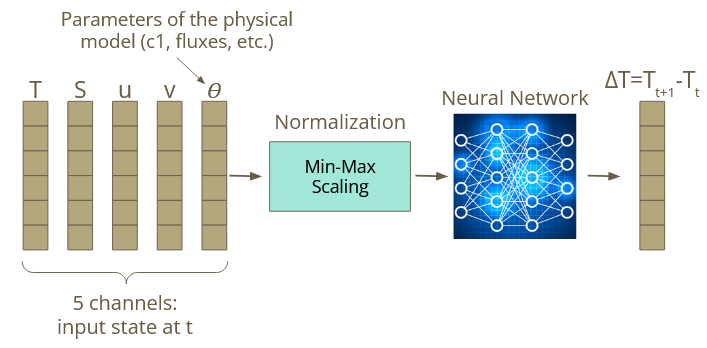

In [1]:
from PIL import Image

image = Image.open('data_process.PNG')
image.show()

In [3]:
n_sim = 10 # metadata to be stored

### 1. Imports

In [2]:
# Useful libraries
import os
import netCDF4
import xarray as xr
import numpy as np
import pandas as pd

### 2. Normalize Data and Generate Labels

min-max scaling formula

"residual" labels

specifically for mlp

In [8]:
def preprocess_and_generate_labels(file_paths):
    """
    Preprocess NetCDF files to create normalized input data and labels.
    
    Parameters:
        file_paths: list of str
            List of paths to NetCDF files.

    Returns:
        combined_data: np.ndarray
            Data frame of stacked normalized data, dimensions: (total_time-len(file_paths), 50, 5).
        labels: np.ndarray
            Data frame of labels, dimensions: (total_time-len(file_paths), 50).
        min_vals: np.array
            Vector of size 5 (minimum of each channel over time and space).
        max_vals: np.array
            Vector of size 5 (maximum of each channel over time and space).
    """
    all_data = []  # To store preprocessed data from all files
    all_labels = []  # To store labels from all files

    for file_path in file_paths:

        # Load NetCDF file
        data = xr.open_dataset(file_path)

        # Extract time dimension
        time_dim = data.dims['time']
        time_dim = time_dim - 1  # Remove last time step - no prediction available for the next state

        # Extract variables
        temperature = data['t'].values
        salinity = data['s'].values
        u_velocity = data['u'].values
        v_velocity = data['v'].values

        # Create a 5th channel containing the varying parameters (strat_t, u, c1) in the first positions
        custom_channel = np.zeros((time_dim,))
        custom_channel[0] = data.attrs.get('strat_t', 0.0)
        custom_channel[1] = data.attrs.get('u', 0.0)
        custom_channel[2] = data.attrs.get('c1', 0.0)

        # Merge as a full matrix (time_dim, 5)
        processed_data = np.column_stack([
            temperature[:time_dim,:],
            salinity[:time_dim,:],
            u_velocity[:time_dim,:],
            v_velocity[:time_dim],
            custom_channel
        ])
        print(len(temperature))
        print(len(temperature[0]))
        print(np.shape(processed_data))

        # Compute labels (temperature delta between t and t+1)
        labels = temperature[1:] - temperature[:-1]

        # Store results
        all_data.append(processed_data)
        all_labels.append(labels)

    # Concatenate all matrices
    combined_data = np.vstack(all_data) # PROBLEM DIM EXPECTED IN THE END (319,50,5)
    combined_labels = np.concatenate(all_labels)

    # Normalize by temperature (min-max scaling)
    min_vals = combined_data.min(axis=0)  # Minimum per column
    max_vals = combined_data.max(axis=0)  # Maximum per column
    #combined_data = (combined_data - min_vals) / (max_vals - min_vals)  # Min-max scaling
    range = max_vals - min_vals
    range = np.where(range == 0, 1, range)  # Avoid dividing by zero
    combined_data = (combined_data - min_vals) / range  # Min-max scaling

    return combined_data, combined_labels, min_vals, max_vals

In [5]:
directory = "data/"  # where simulations files are stored
file_names = [f"traj{i}.nc" for i in range(n_sim)]
file_paths = [os.path.join(directory, name) for name in file_names]

# Preprocess data and generate labels
combined_data, labels, _, _ = preprocess_and_generate_labels(file_paths)

# Print dimensions of preprocessed data
print("Combined data shape:", combined_data.shape)
print("Labels shape:", labels.shape)

# Save results
np.save("data/normalized_combined_processed_data.npy", combined_data)
np.save("data/labels_normalized_data.npy", labels)

360
50
(359, 201)
Combined data shape: (359, 201)
Labels shape: (359, 50)


/tmp/ipykernel_1310/1197204150.py:24: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  time_dim = data.dims['time']


### 3. Split into Train and Test Sets

default 0.8, need test never seen.

In [6]:
def split_data_and_labels(data, labels, train_ratio=0.8, random_seed=None):
    """
    Splits data and labels into train and test sets.

    Parameters:
        data: np.ndarray
            Input data frame, dimensions: (n, num_features).
        labels: np.ndarray
            Labels, dimensions: (n,).
        train_ratio: float
            Data proportion for training (default 0.8).
        random_seed: int or None
            Random seed for reproducibility (default None).

    Returns:
        train_data: np.ndarray
        train_labels: np.ndarray
        test_data: np.ndarray
        test_labels: np.ndarray
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    # Shuffle indices
    num_samples = data.shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    # Indices for train and test sets
    split_idx = int(train_ratio * num_samples)
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]

    # Separate data and labels
    train_data = data[train_indices]
    train_labels = labels[train_indices]
    test_data = data[test_indices]
    test_labels = labels[test_indices]

    return train_data, train_labels, test_data, test_labels, train_indices

In [7]:
# Load pre-processed data and labels
combined_data = np.load("normalized_combined_processed_data.npy")
labels = np.load("labels_normalized_data.npy")

# Split them up
train_data, train_labels, test_data, test_labels, _ = split_data_and_labels(
    combined_data, labels, train_ratio=0.8, random_seed=42
)

# Print their respective size
print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)

# Save each data set
np.save("data/train_data.npy", train_data)
np.save("data/train_labels.npy", train_labels)
np.save("data/test_data.npy", test_data)
np.save("data/test_labels.npy", test_labels)

Train data shape: (287, 201)
Train labels shape: (287, 50)
Test data shape: (72, 201)
Test labels shape: (72, 50)
